### Solve Burgers Eq. using WENO recontruction method

https://sci-hub.hkvisa.net/10.1006/jcph.1994.1187

We solve the Burgers eq.
$$
\partial_t u(x, t) + \partial_x f(u) = 0, \qquad f(u) = u^2 / 2 
$$
using WENOr2 and WENOr3 reconstruction methods to capture shocks in the u(x,t) field.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

%matplotlib widget

@njit
def f(u):
    return 0.5*u*u

@njit
def fp(u):
    return u

In [15]:
@njit
def BC(arr):
    arr[0]  = arr[2]
    arr[1]  = arr[3]    
    arr[-1] = arr[-3]
    arr[-2] = arr[-4]
    return arr

def TDV_RK(r, u_prev, xs, h, dt):
    if r == 2:
        return TDV_RK3(u_prev, xs, h, dt)
    elif r == 3:
        return TDV_RK4(u_prev, xs, h, dt)
    else:
        raise Exception("Order not implemented! r = 2 or 3")

def TDV_RK3(u_prev, xs, h, dt):
    """
    uj_0 = u_prev[j]
    uj_1 = uj_0 + dt * L(uj_0)
    uj_2 = 3 * uj_0 / 4 + uj_1 / 4 + dt *L(uj_1) / 4
    u_new = uj_0 / 3 + 2 * uj_2 / 3 + 2 * dt * L(uj_2) / 3 
    """

    rr = np.zeros_like(u_prev)

    for j in range(4, len(u_prev)-4):
        rr[j] = L(2, j, u_prev, xs, h)

    u_t = u_prev + dt * rr
    u_t = BC(u_t)

    for j in range(4, len(u_prev)-4):
        rr[j] = L(2, j, u_t, xs, h)
    
    u_t = 3 * u_prev / 4 + u_t / 4 + dt * rr / 4
    u_t = BC(u_t)

    for j in range(4, len(u_prev)-4):
        rr[j] = L(2, j, u_t, xs, h)

    u_t = u_prev / 3 + 2 * u_t / 3 + 2 * dt * rr / 3 
    return BC(u_t)

def TDV_RK4(u_prev, xs, h, dt):
    """
    uj_0 = u_prev[j]
    uj_1 = uj_0 + dt * L(uj_0)
    uj_2 = uj_0 / 2 + u_j1 / 2 - dt * L(u_j1) / 4 + dt * L(u_j2) / 2
    u_j3 = uj_0 / 9 + 2 * u_j1 / 9 + 2 * u_j2 / 3 - dt * L(u_j1) / 9 - dt * L(u_j2) / 3 + dt * L(u_j3)
    u_new = u_j1 / 3 + u_j2 / 3 + u_j3 / 3 + dt * L(u_j2) / 6 + dt * L(u_j3) / 6
    """

    r_j1 = np.zeros_like(u_prev)
    r_j2 = np.zeros_like(u_prev)
    r_j3 = np.zeros_like(u_prev)

    for j in range(1, len(u_prev)-1):
        r_j1[j] = L(3, j, u_prev, xs, h)

    u_j1 = u_prev + dt*r_j1
    u_j1[0]  = u_j1[1]
    u_j1[-1] = u_j1[-2]


    for j in range(1, len(u_prev)-1):
        r_j2[j] = L(3, j, u_j1, xs, h)
    
    u_j2 = 0.5*u_prev + 0.5*u_j1 - 0.25*dt*r_j1 + 0.5*dt*r_j2
    u_j2[0]  = u_j2[1]
    u_j2[-1] = u_j2[-2]

    for j in range(1, len(u_prev)-1):
        r_j3[j] = L(3, j, u_j2, xs, h)

    u_j3 = u_prev/9 + 2*u_j1/9 + 2*u_j2/3 - dt*r_j1/9 - dt*r_j2/3 + dt*r_j3
    u_j3[0]  = u_j3[1]
    u_j3[-1] = u_j3[-2]
    
    out = u_j1/3 + u_j2/3 + u_j3/3 + dt*r_j2/6 + dt*r_j3/6
    out[0]  = out[1]
    out[-1] = out[-2]
    return out

In [16]:
def L(r, j, u, xs, h):
    """
    Equation 2.7b

    u  --> array of sol
    xs --> array of grid
    
    x_jm = x_{j - 1/2}
    x_jM = x_{j + 1/2}
    """

    x_jM = xs[j] + h / 2
    x_jm = xs[j] - h / 2
    
    o1 = flux( R(r, j  , x_jM, u, xs, h), R(r, j+1, x_jM, u, xs, h), u) 
    o2 = flux( R(r, j-1, x_jm, u, xs, h), R(r, j  , x_jm, u, xs, h), u)
    return - ( o1 - o2 ) / h

In [17]:
def R(r, j, x_pt, u, xs, h):
    if r == 2:
        return R2(j, x_pt, u, xs, h)
    elif r == 3:
        return R3(j, x_pt, u, xs, h)

def R2(j, x_pt, u, xs, h):
    """
    Equation 3.16
    """
    aj0 = alpha(2, j, 0, u)
    aj1 = alpha(2, j, 1, u)
    d = aj0 + aj1
    r1 = aj0 / d
    r2 = aj1 / d
    out = r1 * interpolants(2, j, x_pt, u, xs, h) + r2 * interpolants(2, j+1, x_pt, u, xs, h)
    return out

def R3(j, x_pt, u, xs, h):
    """
    Equation 3.18
    """
    aj0 = alpha(3, j, 0, u)
    aj1 = alpha(3, j, 1, u)
    aj2 = alpha(3, j, 2, u)
    d = aj0 + aj1 + aj2
    r1 = aj0 / d
    r2 = aj1 / d
    r3 = aj2 / d
    out = r1 * interpolants(3, j, x_pt, u, xs, h) + r2 * interpolants(3, j+1, x_pt, u, xs, h) + r3 * interpolants(3, j+2, x_pt, u, xs, h)
    return out

In [18]:
def alpha(r, j, i, u):
    if r == 2:
        return alpha_r2(j, i, u)
    elif r == 3:
        return alpha_r3(j, i, u)

@njit
def alpha_r2(j, i, u, eps = 1e-5):
    """
    Equations 3.17a & 3.17b 
    """
    if fp(u[j]) > 0:
        if i == 0:
            return 1 / 2 / (eps + SI(2, j, u))**2
        elif i == 1:
            return 1 / (eps + SI(2, j+1, u))**2
    elif fp(u[j]) <= 0:
        if i == 0:
            return 1 / (eps + SI(2, j, u))**2
        elif i == 1:
            return 1 / 2 / (eps + SI(2, j+1, u))**2

@njit
def alpha_r3(j, i, u, eps = 1e-5):
    """
    Equations 3.17a & 3.17b 
    """
    if fp(u[j]) > 0:
        if i == 0:
            return 1 / 12 / (eps + SI(3, j, u))**3
        elif i == 1:
            return 1 / 2 / (eps + SI(3, j+1, u))**3
        elif i == 2:
            return 1 / 4 / (eps + SI(3, j+2, u))**3
    elif fp(u[j]) <= 0:
        if i == 0:
            return 1 / 4 / (eps + SI(3, j, u))**3
        elif i == 1:
            return 1 / 2 / (eps + SI(3, j+1, u))**3
        elif i == 2:
            return 1 / 12 / (eps + SI(3, j+2, u))**3

In [19]:
def interpolants(r, j, x, u, xs, h):
    if r == 2:
        return interp_r2(j, x, u, xs, h)
    elif r == 3:
        return interp_r3(j, x, u, xs, h)

@njit
def interp_r2(j, x, u, xs, h):
    return u[j-1] + (u[j] - u[j-1]) * (x - xs[j-1]) / h

@njit
def interp_r3(j, x, u, xs, h):
    p1 = (u[j] - 2*u[j-1] + u[j-2]) * (x_pt - x[j-1])*(x_pt - x[j-1]) / 2 / h/h 
    p2 = (u[j] - u[j-2]) * (x_pt - x[j-1]) / 2 / h
    p3 = u[j-1] - (u[j] - 2*u[j-1] + u[j-2]) / 24

    return p1 + p2 + p3

In [20]:
@njit
def SI(r, j, u):
    if r == 2:
        return SI_r2(j, u)
    elif r == 3:
        return SI_r3(j, u)

@njit
def SI_r2(j, u):
    return (u[j] - u[j-1])**2

@njit
def SI_r3(j, u):
    p1 = (u[j-1] - u[j-2])**2
    p2 = (u[j] - u[j-1])**2
    p3 = (u[j] - 2*u[j-1] + u[j-2])**2

    return 0.5*(p1 + p2) + p3

In [21]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

def flux(a, b, u):
    """
    Godunov flux function
    Equation 2.5
    """
    if np.abs(a-b) < 1e-10:
        return f(a)
    elif a < b:
        u_cont = interp1d(u, f(u), fill_value="extrapolate")
        return minimize_scalar(u_cont, bounds=(a, b), method='bounded').x
    elif a > b:
        u_cont = interp1d(u, -f(u), fill_value="extrapolate")
        return minimize_scalar(u_cont, bounds=(b, a), method='bounded').x

In [22]:
from tqdm.notebook import tqdm

n_ghost = 2

h = 1e-2
nx = int(2 / h + 5)
xs = np.array([np.NaN if (i == 0) or (i == 1) or (i == nx - 2) or (i == nx - 1) 
                else (i-2)*h - 1 for i in range(nx)])

u_prev = np.zeros(len(xs)) # 2 + phys + 2
# Phys
# u_prev[(xs>-0.1) & (xs < 0.1)] = 1
# np.exp(-200*xs[2:-2]**2)
u_prev = 0.5 + np.sin(np.pi * xs[2:-2])

# Ghosts
u_prev = BC(u_prev)

dt = 1e-3
N_it = 500

r = 2

sol = np.zeros((len(u_prev[2:-2]), 3))
sol[:, 0] = u_prev[2:-2].copy()

for i in tqdm(range(N_it)):
    u_next = TDV_RK(r, u_prev, xs, h, dt)
    u_prev = u_next.copy()

    if (i+1)*dt == 0.318:
       sol[:, 1] = u_next[2:-2].copy()
        
sol[:, 2] = u_next[2:-2].copy()

  0%|          | 0/500 [00:00<?, ?it/s]

ValueError: x and y must have same first dimension, but have shapes (201,) and (197,)

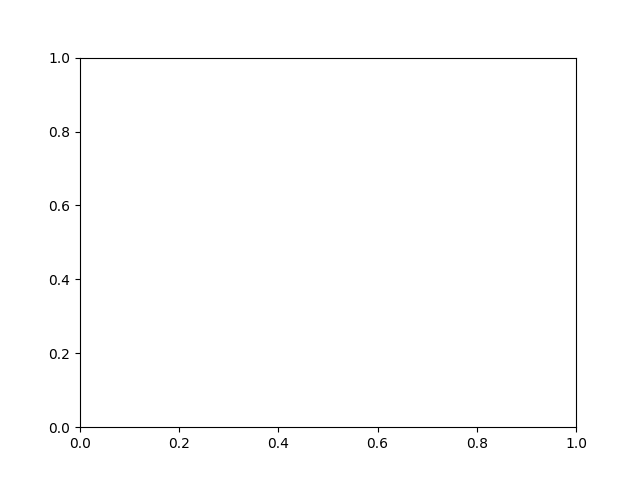

In [23]:
fig = plt.figure()
plt.plot(xs[2:-2], sol[:, 0], '--', label = 'ID')
plt.plot(xs[2:-2], sol[:, 1], label = r't = 0.318 $\sim 1 / \pi$')
plt.plot(xs[2:-2], sol[:, 2], label = 't = 0.5')
plt.legend()

plt.ylim((-0.6,1.6))